In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow numpy matplotlib pandas opencv-python

## VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_images = len(train_generator.filenames)
validation_images = len(validation_generator.filenames)

steps_per_epoch = max(1, train_images // train_generator.batch_size)
validation_steps = max(1, validation_images // validation_generator.batch_size)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)


model.save('/content/drive/MyDrive/stone_detection_model.keras', save_format='keras')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
4/4 [==============================] - 7s 977ms/step - loss: 0.5142 - accuracy: 0.7778 - val_loss: 0.2295 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 2s 490ms/step - loss: 0.1790 - accuracy: 0.9444 - val_loss: 0.4386 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 3s 624ms/step - loss: 0.1693 - accuracy: 0.9444 - val_loss: 0.4087 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 2s 458ms/step - loss: 0.2469 - accuracy: 0.9167 - val_loss: 0.6079 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 2s 468ms/step - loss: 0.2158 - accuracy: 0.9583 - val_loss: 0.6024 - val_accuracy: 0.8500 - lr: 2.0000e-04
Epoch 6/30
4/4 [==============================] - 2s 457ms/step - loss: 0.0793 - accuracy: 0.9500 - val_loss: 0.3308 - val_accuracy: 0.8500 - lr: 2.0000e-04


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/stone_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)


Test Model

In [1]:
import numpy as np
import tensorflow as tf
import cv2

interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/stone_detection_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

IMG_SIZE = (150, 150)

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = np.expand_dims(img, axis=0).astype(np.float32) / 255.0

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])

    return 'Stone' if prediction[0] > 0.5 else 'Not Stone'

test_image_path = '/content/drive/MyDrive/APM/test_images/test_img_8.jpeg'  # Pfad zum Testbild
result = predict_image(test_image_path)
print(f'The image is predicted to be: {result}')

ValueError: Could not open '/content/drive/MyDrive/stone_detection_model.tflite'.

## MobileNet Model

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

IMG_SIZE = (160, 160)

def load_images_from_folder(folder, label, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(label)
    return images, labels

stone_dir = '/content/drive/MyDrive/APM/images/stone'
not_stone_dir = '/content/drive/MyDrive/APM/images/not_stone'

stone_images, stone_labels = load_images_from_folder(stone_dir, 1, IMG_SIZE)
not_stone_images, not_stone_labels = load_images_from_folder(not_stone_dir, 0, IMG_SIZE)

images = np.array(stone_images + not_stone_images)
labels = np.array(stone_labels + not_stone_labels)

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(160, 160, 3)))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=30,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

model.save('/content/drive/MyDrive/stone_detection_model_mobilenet.keras', save_format='keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/stone_detection_model_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/30
3/3 [==============================] - 8s 895ms/step - loss: 1.6058 - accuracy: 0.5301 - val_loss: 0.4478 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 0s 59ms/step - loss: 0.2759 - accuracy: 0.8675 - val_loss: 0.2643 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 0s 61ms/step - loss: 0.5145 - accuracy: 0.8795 - val_loss: 0.0902 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 0s 38ms/step - loss: 0.1369 - accuracy: 0.9759 - val_loss: 0.0985 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 0s 37ms/step - loss: 0.0463 - accuracy: 0.9759 - val_loss: 0.2350 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 6/30
3/3 [==============================] - 0s 42ms/step - loss: 0.0902 - accuracy: 0.9518 - val_loss: 0.1618 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/30
3/3 [======

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
3/3 [==============================] - 4s 747ms/step - loss: 0.0814 - accuracy: 0.9759 - precision: 0.9831 - recall: 0.9831 - val_loss: 0.1209 - val_accuracy: 0.9524 - val_precision: 0.9375 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 0s 93ms/step - loss: 0.0292 - accuracy: 0.9880 - precision: 1.0000 - recall: 0.9831 - val_loss: 0.0373 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 0s 96ms/step - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 0s 95ms/step - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 0s 52ms/step 

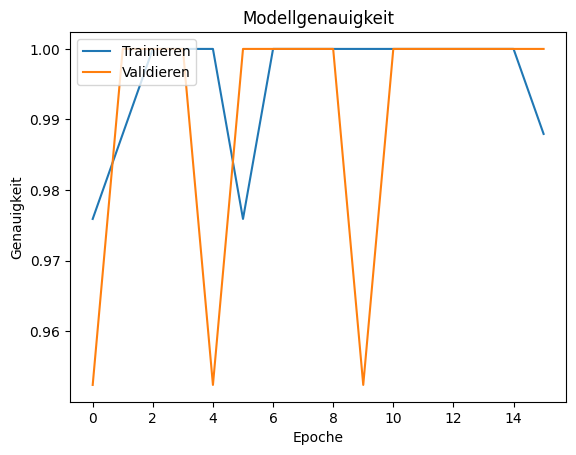

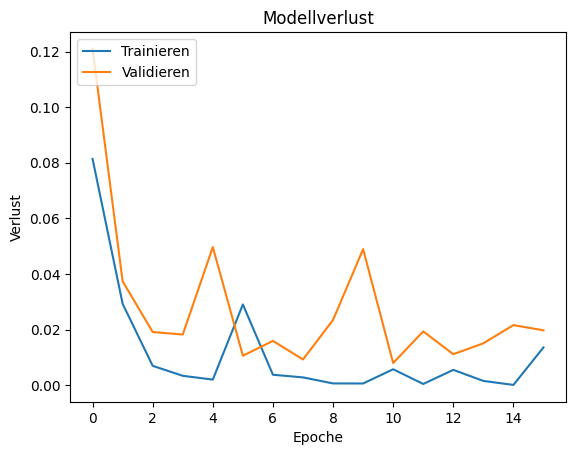

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.ylabel('Genauigkeit')
plt.xlabel('Epoche')
plt.legend(['Trainieren', 'Validieren'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modellverlust')
plt.ylabel('Verlust')
plt.xlabel('Epoche')
plt.legend(['Trainieren', 'Validieren'], loc='upper left')
plt.show()